In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt

#### 1. Реализуйте полносвязную нейронную сеть с помощью библиотеки Tensor Flow. В качестве алгоритма оптимизации можно использовать, например, стохастический градиент (Stochastic Gradient Descent, SGD). Определите количество скрытых слоев от 1 до 5, количество нейронов в каждом из слоев до нескольких сотен, а также их функции активации (кусочно-линейная, сигмоидная, гиперболический тангенс и т.д.).

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']

    del save  # for gc

    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)
    

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

In [4]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

In [5]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [6]:
def accuracy(predictions, labels):
    return np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0] * 100.0

In [7]:
batch_size = 128
num_steps = 5000
hidden_size1 = 300
hidden_size2 = 300
hidden_size3 = 300
beta_val = np.logspace(-4, -2, 20)
accuracy_val = []

In [8]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables
    W1 = tf.get_variable('W1', [image_size * image_size, hidden_size1], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [hidden_size1], initializer=tf.zeros_initializer())

    # Hidden layer 1
    W2 = tf.get_variable('W2', [hidden_size1, hidden_size2], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [hidden_size2], initializer=tf.zeros_initializer())

    # Hidden layer 2
    W3 = tf.get_variable('W3', [hidden_size2, hidden_size3], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [hidden_size3], initializer=tf.zeros_initializer())

    # Hidden layer 3
    W4 = tf.get_variable('W4', [hidden_size3, num_labels], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable('b4', [num_labels], initializer=tf.zeros_initializer())

    # Training computation
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)
    a3 = tf.nn.relu(tf.matmul(a2, W3) + b3)
    logits = tf.matmul(a3, W4) + b4

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    train_prediction = tf.nn.softmax(logits)

    a1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    a2_valid = tf.nn.relu(tf.matmul(a1_valid, W2) + b2)
    a3_valid = tf.nn.relu(tf.matmul(a2_valid, W3) + b3)
    valid_logits = tf.matmul(a3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)

    a1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    a2_test = tf.nn.relu(tf.matmul(a1_test, W2) + b2)
    a3_test = tf.nn.relu(tf.matmul(a2_test, W3) + b3)
    test_logits = tf.matmul(a3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [9]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}

        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(
                valid_prediction.eval(), valid_labels))

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Minibatch loss at step 0: 2.334985
Minibatch accuracy: 10.9%
Validation accuracy: 27.5%
Minibatch loss at step 500: 0.458464
Minibatch accuracy: 87.5%
Validation accuracy: 86.1%
Minibatch loss at step 1000: 0.464164
Minibatch accuracy: 86.7%
Validation accuracy: 88.0%
Minibatch loss at step 1500: 0.489116
Minibatch accuracy: 82.8%
Validation accuracy: 88.4%
Minibatch loss at step 2000: 0.302112
Minibatch accuracy: 92.2%
Validation accuracy: 88.3%
Minibatch loss at step 2500: 0.320131
Minibatch accuracy: 87.5%
Validation accuracy: 89.0%
Minibatch loss at step 3000: 0.385310
Minibatch accuracy: 89.8%
Validation accuracy: 89.5%
Minibatch loss at step 3500: 0.326352
Minibatch accuracy: 91.4%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.385051
Minibatch accuracy: 89.1%
Validation accuracy: 89.7%
Minibatch loss at step 4500: 0.199415
Minibatch accuracy: 94.5%
Validation accuracy: 89.7%
Test accuracy: 94.9%

#### Задание 2. Как улучшилась точность классификатора по сравнению с логистической регрессией?

Я использовал полносвязную нейронную сеть с тремя слоями по 300 нейронов в каждой,
с функцией активации RelU на скрытых слоях и softmax на выходном слое.
Точность классификатора выросла на 5.2 процента по сравнению с логистической регрессией:
теперь она составляет 94.8%

#### Задание 3. Используйте регуляризацию и метод сброса нейронов (dropout) для борьбы с переобучением. Как улучшилось качество классификации?

In [10]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regularization = tf.placeholder(tf.float32)

    # Variables
    W1 = tf.get_variable('W1', [image_size * image_size, hidden_size1],
                         initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [hidden_size1], initializer=tf.zeros_initializer())

    # Hidden layer 1
    W2 = tf.get_variable('W2', [hidden_size1, hidden_size2], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [hidden_size2], initializer=tf.zeros_initializer())

    # Hidden layer 2
    W3 = tf.get_variable('W3', [hidden_size2, hidden_size3], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [hidden_size3], initializer=tf.zeros_initializer())

    # Hidden layer 3
    W4 = tf.get_variable('W4', [hidden_size3, num_labels], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable('b4', [num_labels], initializer=tf.zeros_initializer())

    # Training computation
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)
    a3 = tf.nn.relu(tf.matmul(a2, W3) + b3)
    logits = tf.matmul(a3, W4) + b4

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
           regularization * (
                   tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) +
                   tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                   tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) +
                   tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    train_prediction = tf.nn.softmax(logits)

    a1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    a2_valid = tf.nn.relu(tf.matmul(a1_valid, W2) + b2)
    a3_valid = tf.nn.relu(tf.matmul(a2_valid, W3) + b3)
    valid_logits = tf.matmul(a3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)

    a1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    a2_test = tf.nn.relu(tf.matmul(a1_test, W2) + b2)
    a3_test = tf.nn.relu(tf.matmul(a2_test, W3) + b3)
    test_logits = tf.matmul(a3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)

L2 regularization(beta=0.00010) Test accuracy: 94.2%
L2 regularization(beta=0.00013) Test accuracy: 94.8%
L2 regularization(beta=0.00016) Test accuracy: 94.5%
L2 regularization(beta=0.00021) Test accuracy: 94.5%
L2 regularization(beta=0.00026) Test accuracy: 94.6%
L2 regularization(beta=0.00034) Test accuracy: 94.2%
L2 regularization(beta=0.00043) Test accuracy: 94.5%
L2 regularization(beta=0.00055) Test accuracy: 94.2%
L2 regularization(beta=0.00070) Test accuracy: 94.0%
L2 regularization(beta=0.00089) Test accuracy: 92.9%
L2 regularization(beta=0.00113) Test accuracy: 93.7%
L2 regularization(beta=0.00144) Test accuracy: 92.5%
L2 regularization(beta=0.00183) Test accuracy: 93.1%
L2 regularization(beta=0.00234) Test accuracy: 92.3%
L2 regularization(beta=0.00298) Test accuracy: 91.9%
L2 regularization(beta=0.00379) Test accuracy: 91.7%
L2 regularization(beta=0.00483) Test accuracy: 91.4%
L2 regularization(beta=0.00616) Test accuracy: 89.7%
L2 regularization(beta=0.00785) Test accuracy:

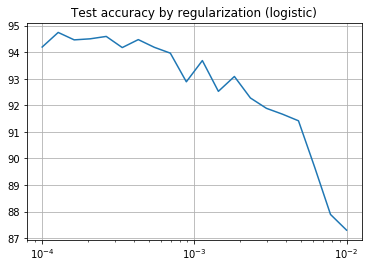

In [11]:
for beta in beta_val:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()

        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        print("L2 regularization(beta=%.5f) Test accuracy: %.1f%%" % (beta, accuracy(test_prediction.eval(), test_labels)))
        accuracy_val.append(accuracy(test_prediction.eval(), test_labels))

print('Best beta=%f, accuracy=%.1f%%' % (beta_val[np.argmax(accuracy_val)], max(accuracy_val)))
plt.semilogx(beta_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Для данной НС регуляризация почти не улучшила точность классификатора (+0.1% в сравнении с предыдущей моделью).
Далее будем использовать значении регуляризации 0.00016, при котором НС показала наилучшую точность 94.9%

In [12]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regularization = tf.placeholder(tf.float32)

    # Variables
    W1 = tf.get_variable('W1', [image_size * image_size, hidden_size1],
                         initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', [hidden_size1], initializer=tf.zeros_initializer())

    # Hidden layer 1
    W2 = tf.get_variable('W2', [hidden_size1, hidden_size2], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', [hidden_size2], initializer=tf.zeros_initializer())

    # Hidden layer 2
    W3 = tf.get_variable('W3', [hidden_size2, hidden_size3], initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', [hidden_size3], initializer=tf.zeros_initializer())

    # Hidden layer 3
    W4 = tf.get_variable('W4', [hidden_size3, num_labels], initializer=tf.contrib.layers.xavier_initializer())
    b4 = tf.get_variable('b4', [num_labels], initializer=tf.zeros_initializer())

    # Training computation
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    a1 = tf.nn.dropout(a1, 0.9)
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)
    a2 = tf.nn.dropout(a2, 0.9)
    a3 = tf.nn.relu(tf.matmul(a2, W3) + b3)
    a3 = tf.nn.dropout(a3, 0.9)
    logits = tf.matmul(a3, W4) + b4

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
           regularization * (
                   tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) +
                   tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                   tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) +
                   tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    train_prediction = tf.nn.softmax(logits)

    a1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    a2_valid = tf.nn.relu(tf.matmul(a1_valid, W2) + b2)
    a3_valid = tf.nn.relu(tf.matmul(a2_valid, W3) + b3)
    valid_logits = tf.matmul(a3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)

    a1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    a2_test = tf.nn.relu(tf.matmul(a1_test, W2) + b2)
    a3_test = tf.nn.relu(tf.matmul(a2_test, W3) + b3)
    test_logits = tf.matmul(a3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization: 0.00016}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

    print("Dropout Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 2.421176
Minibatch accuracy: 3.9%
Validation accuracy: 35.6%
Minibatch loss at step 500: 0.589561
Minibatch accuracy: 84.4%
Validation accuracy: 85.9%
Minibatch loss at step 1000: 0.599794
Minibatch accuracy: 84.4%
Validation accuracy: 87.1%
Minibatch loss at step 1500: 0.577289
Minibatch accuracy: 83.6%
Validation accuracy: 87.9%
Minibatch loss at step 2000: 0.446838
Minibatch accuracy: 89.1%
Validation accuracy: 88.5%
Minibatch loss at step 2500: 0.496118
Minibatch accuracy: 87.5%
Validation accuracy: 88.7%
Minibatch loss at step 3000: 0.466086
Minibatch accuracy: 89.8%
Validation accuracy: 89.2%
Minibatch loss at step 3500: 0.425851
Minibatch accuracy: 90.6%
Validation accuracy: 89.0%
Minibatch loss at step 4000: 0.456536
Minibatch accuracy: 86.7%
Validation accuracy: 89.4%
Minibatch loss at step 4500: 0.358285
Minibatch accuracy: 91.4%
Validation accuracy: 89.8%
Dropout Test accuracy: 94.7%


Применение техники dropout не привело к увеличению качества классфикации.
Вероятно НС не имеет признаков переобучения и поэтому, в данном случае, применение dropout только увеличивает ошибку обучения.

#### Задание 4. Воспользуйтесь динамически изменяемой скоростью обучения (learning rate). Наилучшая точность, достигнутая с помощью данной модели составляет 97.1%. Какую точность демонстрирует Ваша реализованная модель?

In [14]:
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    regularization = tf.placeholder(tf.float32)
    global_step = tf.Variable(0)

    # Variables
    W1 = tf.Variable(
        tf.truncated_normal([image_size * image_size, hidden_size1], stddev=np.sqrt(2.0 / (image_size * image_size))))
    b1 = tf.Variable(tf.zeros([hidden_size1]))

    W2 = tf.Variable(tf.truncated_normal([hidden_size1, hidden_size2], stddev=np.sqrt(2.0 / hidden_size1)))
    b2 = tf.Variable(tf.zeros([hidden_size2]))

    W3 = tf.Variable(tf.truncated_normal([hidden_size2, hidden_size3], stddev=np.sqrt(2.0 / hidden_size2)))
    b3 = tf.Variable(tf.zeros([hidden_size3]))

    W4 = tf.Variable(tf.truncated_normal([hidden_size3, num_labels], stddev=np.sqrt(2.0 / hidden_size3)))
    b4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation
    a1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)
    a3 = tf.nn.relu(tf.matmul(a2, W3) + b3)
    logits = tf.matmul(a3, W4) + b4

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
           regularization * (
                   tf.nn.l2_loss(W1) + tf.nn.l2_loss(b1) +
                   tf.nn.l2_loss(W2) + tf.nn.l2_loss(b2) +
                   tf.nn.l2_loss(W3) + tf.nn.l2_loss(b3) +
                   tf.nn.l2_loss(W4) + tf.nn.l2_loss(b4))

    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.7, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    train_prediction = tf.nn.softmax(logits)

    a1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    a2_valid = tf.nn.relu(tf.matmul(a1_valid, W2) + b2)
    a3_valid = tf.nn.relu(tf.matmul(a2_valid, W3) + b3)
    valid_logits = tf.matmul(a3_valid, W4) + b4
    valid_prediction = tf.nn.softmax(valid_logits)

    a1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    a2_test = tf.nn.relu(tf.matmul(a1_test, W2) + b2)
    a3_test = tf.nn.relu(tf.matmul(a2_test, W3) + b3)
    test_logits = tf.matmul(a3_test, W4) + b4
    test_prediction = tf.nn.softmax(test_logits)

In [15]:
num_steps = 5000
hidden_size1 = 4000
hidden_size2 = 2000
hidden_size3 = 100

In [16]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, regularization: 0.00016}

        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

        if step % 500 == 0:
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))

    print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 2.452325
Minibatch accuracy: 12.5%
Validation accuracy: 33.5%
Minibatch loss at step 500: 0.582550
Minibatch accuracy: 86.7%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 0.533436
Minibatch accuracy: 88.3%
Validation accuracy: 88.1%
Minibatch loss at step 1500: 0.580822
Minibatch accuracy: 83.6%
Validation accuracy: 88.5%
Minibatch loss at step 2000: 0.385167
Minibatch accuracy: 91.4%
Validation accuracy: 89.1%
Minibatch loss at step 2500: 0.437295
Minibatch accuracy: 89.8%
Validation accuracy: 89.5%
Minibatch loss at step 3000: 0.421934
Minibatch accuracy: 92.2%
Validation accuracy: 90.0%
Minibatch loss at step 3500: 0.409220
Minibatch accuracy: 91.4%
Validation accuracy: 90.2%
Minibatch loss at step 4000: 0.382378
Minibatch accuracy: 92.2%
Validation accuracy: 90.4%
Minibatch loss at step 4500: 0.302190
Minibatch accuracy: 92.2%
Validation accuracy: 90.4%
Final Test accuracy: 95.3%


С помощью динамически изменяемой скорости обучения удалось достичь точности 95.3%
